1.2512509381253906e-06
tensor([0.0000, 0.0400, 0.0800, 0.1200, 0.1600, 0.2000, 0.2400, 0.2800, 0.3200,
        0.3600, 0.4000, 0.4400, 0.4800, 0.5200, 0.5600, 0.6000, 0.6400, 0.6800,
        0.7200, 0.7600, 0.8000, 0.8400, 0.8800, 0.9200, 0.9600])
tensor([0.0500, 0.0900, 0.1300, 0.1700, 0.2100, 0.2500, 0.2900, 0.3300, 0.3700,
        0.4100, 0.4500, 0.4900, 0.5300, 0.5700, 0.6100, 0.6500, 0.6900, 0.7300,
        0.7700, 0.8100, 0.8500, 0.8900, 0.9300, 0.9700, 1.0000])
IC loss:  18856.395263671875 BC loss:  4.172093700617552 PDE loss:  1.5388126485049725
IC loss:  18856.24267578125 BC loss:  3.595443442463875 PDE loss:  1.223320432472974
IC loss:  18856.0986328125 BC loss:  3.0651672277599573 PDE loss:  0.9410846541868523
IC loss:  18855.958251953125 BC loss:  2.536912215873599 PDE loss:  0.7004734652582556
IC loss:  18855.823974609375 BC loss:  2.1158407907932997 PDE loss:  0.49978272727457806
IC loss:  18855.69580078125 BC loss:  1.7029097070917487 PDE loss:  0.3378010296728462
IC los

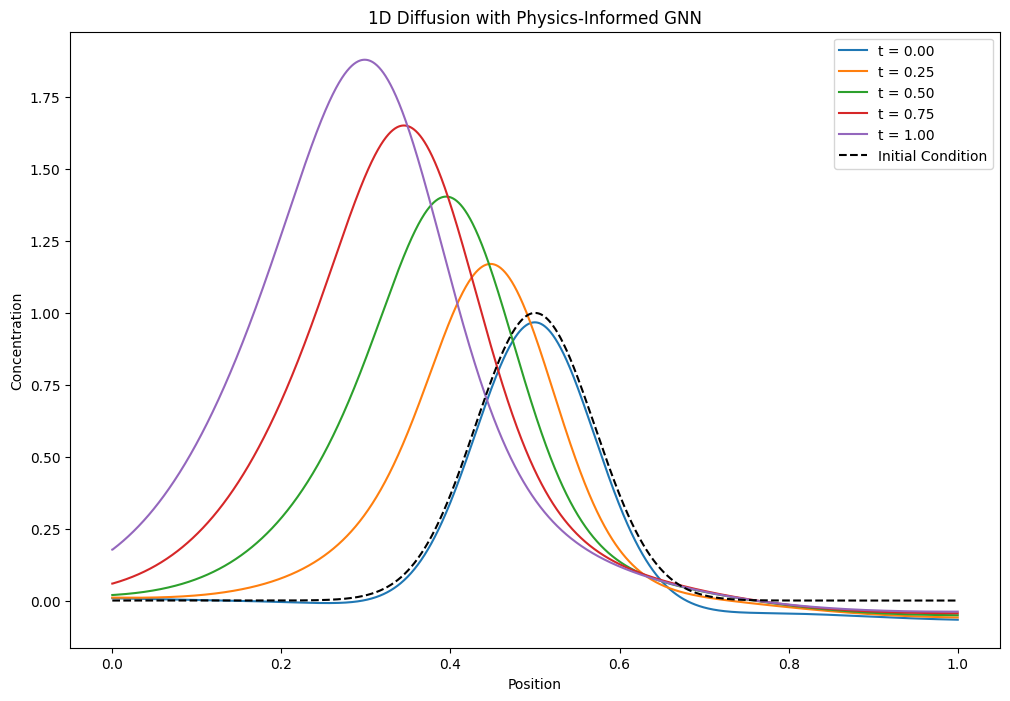

In [58]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)

# Define the Physics-Informed GNN model
class PINNGNN(MessagePassing):
    def __init__(self, time_window=2):
        super().__init__(aggr='mean')  # mean aggregation
        self.node_nn = nn.Sequential(
            nn.Linear(2, 32),  # input: (x, t)
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)   # output: u(x,t)
        )
        self.time_window = time_window
    def forward(self, x, t, edge_index):
        # Concatenate spatial and time coordinates as node features
        node_features = torch.cat([x, t], dim=1)
        # Propagate messages on the fixed graph (using the given edge_index)
        out = self.propagate(edge_index, x=node_features, t=t)
        # Final prediction through the node network
        return self.node_nn(out)
    
    def message(self, x_i, x_j, t_i, t_j):
        time_diff = torch.abs(t_j - t_i)
        time_window_mask =(time_diff <= self.time_window).flatten()
        messages = x_j.clone()
        messages[~time_window_mask] = 0
        return messages
    
    def update(self, aggr_out):
        return aggr_out

# Parameters
alpha = 0.1         # Diffusion coefficient
L = 1.0             # Domain length
T = 1.0             # Total time
N = 2000             # Number of spatial nodes (graph nodes)
num_epochs = 50   # Number of training epochs

dx = L / (N - 1)
dt_max_diffusion = (dx**2)/(2*alpha)
print(dt_max_diffusion)

# Fixed spatial grid (this defines the graph nodes)
x_domain = torch.linspace(0, L, N).view(-1, 1)

# Define the initial condition function (Gaussian)
def u0(x):
    return torch.exp(- (x - 0.5)**2 / 0.01)

# Build graph connectivity for the fixed spatial grid (1D chain)
edge_index = []
for i in range(N - 1):
    edge_index.append([i, i + 1])
    edge_index.append([i + 1, i])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
# Add self-loops for improved gradient flow
edge_index, _ = add_self_loops(edge_index)

model = PINNGNN(time_window=dt_max_diffusion)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

import math
#what if I want overlap between temporal batches?
dt = 0.05
overlap = 0.2
effective_dt = (1-overlap)*dt
n_pieces_temporal = math.ceil(T/effective_dt)
start_times = torch.arange(0, T, effective_dt)
end_times = start_times + dt
end_times[-1] = T

print(start_times)
print(end_times)

# Training loop
for epoch in range(num_epochs):
    
    #Fixed for epoch
    epoch_loss = 0

    for t_start, t_end in zip(start_times, end_times):
        
        x_colloc_onedomain = x_domain.clone().detach().requires_grad_(True)
        #triplicate x_colloc for each time
        x_colloc = x_colloc_onedomain.repeat(3, 1)
        t_colloc = torch.rand(x_colloc_onedomain.shape) * (t_end - t_start) + t_start
        t_initial = torch.rand(x_colloc_onedomain.shape) * 0.1
        t_final = torch.rand(x_colloc_onedomain.shape) * 0.1 + 0.9
        t_colloc = torch.cat([t_colloc, t_initial, t_final], dim=0)

        t_colloc.requires_grad_(True)
        # Forward pass for collocation points
        u_colloc = model(x_colloc, t_colloc, edge_index)
    
        def closure():
            optimizer.zero_grad()
            # Forward pass for collocation points
            u_colloc = model(x_colloc, t_colloc, edge_index)
            
            # Compute spatial derivatives for PDE residual
            grad_u = torch.autograd.grad(u_colloc, x_colloc,
                                        grad_outputs=torch.ones_like(u_colloc),
                                        create_graph=True)[0]
            grad_u2 = torch.autograd.grad(grad_u, x_colloc,
                                        grad_outputs=torch.ones_like(grad_u),
                                        create_graph=True)[0]
            # Compute time derivative
            time_deriv = torch.autograd.grad(u_colloc, t_colloc,
                                            grad_outputs=torch.ones_like(u_colloc),
                                            create_graph=True)[0]
            
            # PDE residual: u_t - alpha * u_xx = 0
            pde_res = time_deriv - alpha * grad_u2
            pde_loss = (pde_res ** 2).mean()
            
            # --------------------------
            # Boundary Condition (Neumann: du/dx = 0 at x=0 and x=L)
            # --------------------------
            bc_loss = ((grad_u[0])**2 + (grad_u[-1])**2).mean()
            
            # --------------------------
            # Initial Condition: u(x,0) = u0(x)
            # --------------------------
            # Use the same spatial grid at time t=0
            x_initial = x_domain.clone().detach().requires_grad_(True)
            t_initial = torch.zeros_like(x_initial)
            u_initial = model(x_initial, t_initial, edge_index)
            
            # Loss on the function values
            ic_loss = ((u_initial - u0(x_initial))**2).mean()
            
            # Compute the first derivative of u_initial with respect to x
            grad_u_initial = torch.autograd.grad(u_initial, x_initial,
                                                grad_outputs=torch.ones_like(u_initial),
                                                create_graph=True)[0]
            # Compute the second derivative of u_initial with respect to x
            grad_u_initial2 = torch.autograd.grad(grad_u_initial, x_initial,
                                                grad_outputs=torch.ones_like(grad_u_initial),
                                                create_graph=True)[0]
            
            # Analytical derivatives of the initial condition u0(x)
            u0_val = u0(x_initial)
            u0_first_deriv = -2 * (x_initial - 0.5) / 0.01 * u0_val
            u0_second_deriv = (-2/0.01 + 4*(x_initial - 0.5)**2/0.01**2) * u0_val
            
            # Loss on the derivatives: mean squared error between the model's and analytical derivatives
            deriv_loss_first = ((grad_u_initial - u0_first_deriv)**2).mean()
            deriv_loss_second = ((grad_u_initial2 - u0_second_deriv)**2).mean()
            ic_deriv_loss = deriv_loss_first + deriv_loss_second
            
            # Combine the initial condition losses
            # You can adjust the weights (e.g., lambda_deriv) to balance the contributions.
            lambda_deriv = 0.5  # hyperparameter to tune
            total_ic_loss = ic_loss + lambda_deriv * ic_deriv_loss
            # Total loss is the sum of the three components
            lambda_pde = 5000
            lambda_bc = 500
            lambda_initial = 10
            print("IC loss: ", lambda_initial*total_ic_loss.item(), "BC loss: ", lambda_bc*bc_loss.item(), "PDE loss: ", lambda_pde*pde_loss.item())
            total_loss = lambda_initial*total_ic_loss + lambda_bc*bc_loss + lambda_pde*pde_loss
            total_loss.backward()
            return total_loss

    
        loss =optimizer.step(closure)
        epoch_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Total average loss: {epoch_loss/len(start_times)}")

# --------------------------
# Testing / Visualization
# --------------------------
# Evaluate the trained model at the fixed spatial nodes for a few time values
t_vals = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.figure(figsize=(12, 8))
for t_val in t_vals:
    # Create a time tensor for all nodes
    t_test = torch.full(x_domain.shape, t_val)
    with torch.no_grad():
        u_pred = model(x_domain, t_test, edge_index)
    plt.plot(x_domain.numpy(), u_pred.numpy(), label=f"t = {t_val:.2f}")

# Also plot the initial condition (dashed line)
plt.plot(x_domain.numpy(), u0(x_domain).numpy(), 'k--', label="Initial Condition")
plt.xlabel("Position")
plt.ylabel("Concentration")
plt.title("1D Diffusion with Physics-Informed GNN")
plt.legend()
plt.show()

#it might have potential if we include dataset 1D domain - PDF at different times?
#for now this is kind of learning based on x,t point values

#adding derivatives to the loss might help?
#Understand the link between GNN and the LSTM to match time series?

 


In [ ]:
!pip install torch